# **Introduction**

This notebook is for implementing a vanilla Actor-Critic method based on the advantage function (A2C), for learning an optimal policy for the `Cartpole` environment. The Actor-Critic method utilizes two networks, one of which is responsible for mapping states to a probability distribution over the actions (actor), and another which estimates the value of a state to guide the actor (critic). The general idea is that the actor updates its policy in the direction suggested by the critic.

Also, as per [this paper](https://proceedings.mlr.press/v97/ahmed19a/ahmed19a.pdf), I am also implementing entropy regularization in an attempt to reduce variance and improve performance.

# **Import Packages**

This section imports the necessary packages.

In [693]:
# import these packages:
import gymnasium as gym
import numpy as np
import random
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
tf.get_logger().setLevel('INFO')
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

from collections import deque

# **Environment Setup**

This section sets up the environment and defines the relevant functions needed for this implementation.

##### Function for making Keras models:

In [694]:
# function for making a keras model:
def make_model(layers, neurons, rate, norm, drop, input_shape, output_shape, loss_function, output_activation):
    # instantiate model:
    model = keras.Sequential()

    # add hidden layers:
    for i in range(layers):
        if i == 0:
            model.add(Input(shape = (input_shape, )))
            model.add(Dense(neurons, activation = 'relu', name = f'hidden_layer_{i+1}'))
        else:
            model.add(Dense(neurons, activation = 'relu', name = f'hidden_layer_{i+1}'))

        if norm == True:
            model.add(BatchNormalization(name = f'batch_norm_layer_{i+1}'))

        if drop == True:
            model.add(Dropout(0.2, name = f'dropout_layer_{i+1}'))
    
    # add output layer:
    model.add(Dense(output_shape, activation = output_activation, name = 'output_layer'))

    # compile the model:
    model.compile(optimizer = Adam(learning_rate = rate),
                  loss = loss_function)
    
    return model 

##### A2C class:

In [695]:
# A2C class:
class A2C_Agent:
    ####################### INITIALIZATION #######################
    # constructor:
    def __init__(self,
                env: gym.Env,
                gamma: float, 
                lr_a: float, 
                lr_c: float,
                beta: float,
                layers = int,
                neurons = int,
                seed = int):
        """ 
        this is the constructor for the agent. this agent uses the advantage actor-critic (A2C) algorithm to learn an optimal policy,
        through the use of two approximator networks. the first network, called the actor, is responsible for providing the probabilty 
        distribution over all actions given a state. the second network, called the critic, is responsible for utilizing the advantage function
        to guide the learning of the actor.

        env:                a gymnasium environment
        gamma:              a float value indicating the discount factor, γ
        lr_a:               a float value indicating the learning rate of the actor, α_a
        lr_c:               a float value indicating the learning rate of the critic, α_c
        beta:               a float value indicating the entropy regularization parameter, β
        layers:             an int value indicating the number of layers in a network
        neurons:            an int value indicating the number of neurons per layer
        seed:               an int value indicating the desired seed, for use in randomization and reproducability

        nS:                 an int representing the number of states observed, each of which is continuous
        nA:                 an int representing the number of discrete actions that can be taken

        actor_network:      a Keras sequential neural network representing the actor
        critic_network:     a Keras sequential neural network representing the actor

        """
        # object parameters:
        self.env = env
        self.gamma = gamma
        self.lr_a = lr_a
        self.lr_c = lr_c
        self.beta = beta

        # get the environment dimensions:
        self.nS = env.observation_space.shape[0]
        self.nA = env.action_space.n

        # initialize the networks:
        self.actor_network = make_model(layers = layers,
                                        neurons = neurons,
                                        rate = lr_a,
                                        norm = False,
                                        drop = False,
                                        input_shape = self.nS,
                                        output_shape = self.nA,
                                        loss_function = "categorical_crossentropy",
                                        output_activation = "softmax")
        
        self.critic_network = make_model(layers = layers,
                                        neurons = neurons,
                                        rate = lr_c,
                                        norm = False,
                                        drop = False,
                                        input_shape = self.nS,
                                        output_shape = 1,
                                        loss_function = "mse",
                                        output_activation = "linear")
        
        # set the seed:
        self.seed = seed
    
    ####################### TRAINING #######################
    # decorated training step function:
    @tf.function
    def training_step(self, states, actions, rewards, next_states, dones):
        # convert values to tensors:
        states = tf.convert_to_tensor(states[None, :], dtype = tf.float32)
        actions = tf.convert_to_tensor(actions, dtype = tf.int32)
        rewards = tf.convert_to_tensor(rewards, dtype = tf.float32)
        next_states = tf.convert_to_tensor(next_states[None, :], dtype = tf.float32)
        dones = tf.convert_to_tensor(dones, dtype = tf.float32)

        # critic update:
        with tf.GradientTape() as critic_tape:
            # pass state through critic:
            value = self.critic_network(states, training = True)

            # get next value:
            next_value = self.critic_network(next_states, training = False)

            # compute target:
            target = rewards + self.gamma * next_value * (1 - dones)

            # compute critic loss:
            critic_loss = tf.reduce_mean(tf.square(target - value))

        # backpropagate and update critic:
        critic_grads = critic_tape.gradient(critic_loss, self.critic_network.trainable_variables)
        self.critic_network.optimizer.apply_gradients(zip(critic_grads, self.critic_network.trainable_variables))

        # actor update:
        with tf.GradientTape() as actor_tape:
            # pass state through actor to get probs:
            probs = self.actor_network(states, training = True)

            # get a mask of the actions chosen:
            action_masks = tf.one_hot(actions, probs.shape[1])

            # take the log of the probs to score the policy:
            log_probs_chosen = tf.reduce_sum(action_masks * tf.math.log(probs + 1e-8), axis = 1)

            # calculate entropy, calculating pi(a|s) * log(a|s) for all actions:
            entropy_per_sample = -tf.reduce_sum(probs * tf.math.log(probs + 1e-8), axis = 1)

            # compute advantage:
            advantage = tf.stop_gradient(target - value)
            
            # compute actor loss, negative to maximize (ascent):
            actor_loss = -tf.reduce_mean(log_probs_chosen * advantage) - self.beta * tf.reduce_mean(entropy_per_sample)

        # backpropagate and update actor:
        actor_grads = actor_tape.gradient(actor_loss, self.actor_network.trainable_variables)
        self.actor_network.optimizer.apply_gradients(zip(actor_grads, self.actor_network.trainable_variables))

        # return losses:
        # return actor_loss, critic_loss

    # gymnasium training function:
    def train(self, training_length):
        # 1) initialize reward history:
        reward_history = np.zeros(training_length)

        # for every episode:
        for episode in tqdm(range(training_length), colour = "#33FF00", ncols = 100, desc = "training progress"):
            # 2) initialize per episode:
            obs, _ = self.env.reset()   # get initial state
            episode_reward = 0          # counter for reward earned this episode
            done = False                # flag for completion

            # while not false:
            while not done:
                # 3) pick an action from the actor network output:
                obs_tensor = tf.convert_to_tensor(obs[None, :], dtype = tf.float32)
                probs = self.actor_network(obs_tensor, training = False)
                action = np.random.choice(len(probs[0]), p = probs.numpy()[0])

                # 4) step the environment:
                next_obs, reward, term, trunc, _ = self.env.step(action)
                episode_reward += reward
                done = term or trunc

                # 5) training step:
                self.training_step(obs, action, reward, next_obs, done)

                # 6) advance state:
                obs = next_obs
            
            # 7) advance reward history:
            reward_history[episode] = episode_reward
        
        # 8) return to user:
        return reward_history


# **Using the Environment**

This section utilizes the above A2C implementation to create an environment and train an agent.

##### Specify hyperparameters:

In [ ]:
# agent hyperparameters:
lr_a = 1e-5             # learning rate for the actor, α_a
lr_c = 1e-4             # learning rate for the actor, α_c
gamma = 0.99            # discount factor γ
beta = 0.01             # entropy scaling value
train_length = 2000     # number of episodes to train for

layers = 3      # how many layers to have in each network
neurons = 32    # how many neurons to have in each layer of each network

seed = 18       # seed for reproducability

##### Initialize the environment and agent:

In [697]:
# create the environment:
env = gym.make("CartPole-v1")

# clear the backend:
tf.keras.backend.clear_session()

# instantiate the agent:
ac_agent = A2C_Agent(env = env,
                    lr_a = lr_a,
                    lr_c = lr_c,
                    beta = beta,
                    gamma = gamma,
                    layers = layers,
                    neurons = neurons, 
                    seed = seed
                    )

_, _ = ac_agent.env.reset(seed = ac_agent.seed)

##### Train the agent:

In [698]:
# training:
reward_history = ac_agent.train(training_length = train_length)

training progress: 100%|██████████████████████████████████████████| 500/500 [04:06<00:00,  2.03it/s]


##### Plotting the results:

average reward was: 153.3811


Text(0, 0.5, 'reward earned | mean reward: 153.381')

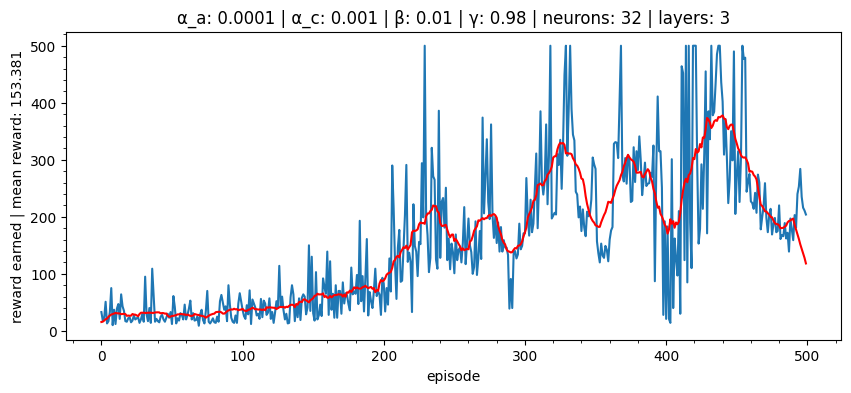

In [699]:
# moving average function:
def moving_average(interval, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(interval, window, 'same')

filtered_data = moving_average(reward_history, 20)

print(f"average reward was: {np.mean(filtered_data)}")

figure = plt.figure(figsize = (10, 4))
plt.plot(reward_history)
plt.plot(filtered_data, 'r-')
plt.minorticks_on()
plt.title(f"α_a: {lr_a} | α_c: {lr_c} | β: {beta} | γ: {gamma} | neurons: {neurons} | layers: {layers}")
plt.xlabel('episode')
plt.ylabel(f'reward earned | mean reward: {np.mean(filtered_data).round(3)}')